In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import imutils
import pandas as pd
import pytesseract
import plantcv as pcv
import matplotlib
%matplotlib notebook

<IPython.core.display.Javascript object>


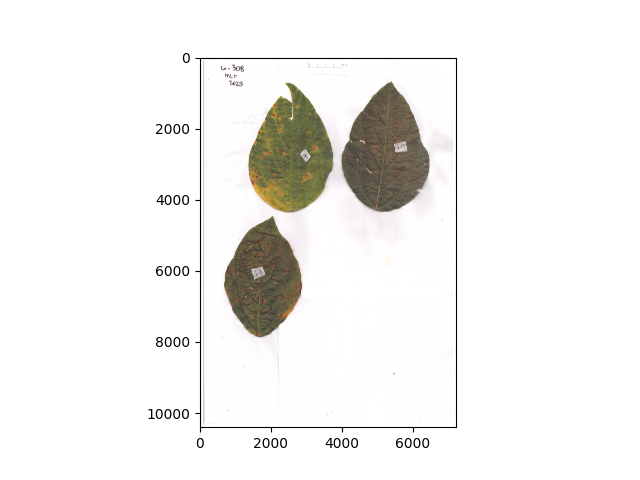

In [2]:
#im = cv.imread("/Users/quino070/LeafShapeAnalysis/images/418-2024-09-13.tif") #ductape
#im = cv.imread("/Users/quino070/LeafShapeAnalysis/images/103_2024-08-30.tif") #ductape AND sticker - leaf with holes doesnt work
#im = cv.imread("/Users/quino070/LeafShapeAnalysis/images/040-2024-09-10.tif")
#im = cv.imread("/Users/quino070/LeafShapeAnalysis/images/100_2024-08-30.tif") #no tag, ID on leaf - this one wont work
#im = cv.imread("/Users/quino070/LeafShapeAnalysis/images/102_2024-08-30.tif") #sticker tag
im = cv.imread("/Users/quino070/LeafShapeAnalysis/images/LO-308_All2_2025.tif")
#im = cv.imread("/Users/quino070/LeafShapeAnalysis/images/LO-369_All1_2025.tif")

im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
#adding border to fix leaves too close to the edge
im = cv.copyMakeBorder(im, 100, 100, 100, 100,
                                    cv.BORDER_CONSTANT, value=(255, 255, 255)) 
plt.figure()
plt.imshow(im)

<IPython.core.display.Javascript object>


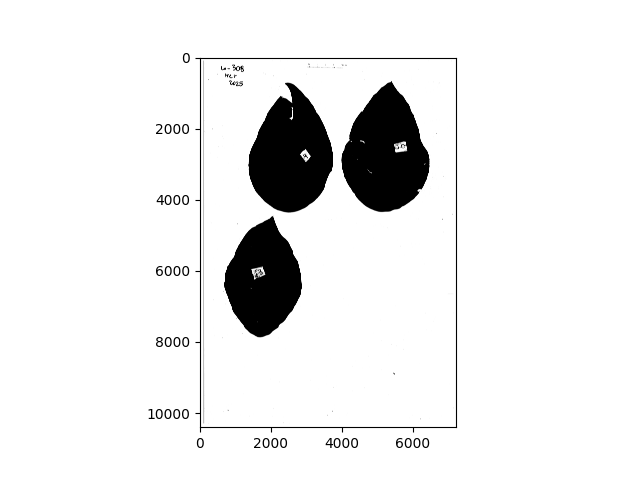

In [3]:
#Make grayscale to create binary mask
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
#otsu_ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
#offset = 45
#_, thresh = cv.threshold(gray, otsu_ret-offset, 255, cv.THRESH_BINARY)
_, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY+ cv.THRESH_OTSU)

plt.figure()
plt.imshow(thresh, cmap="gray")

<IPython.core.display.Javascript object>


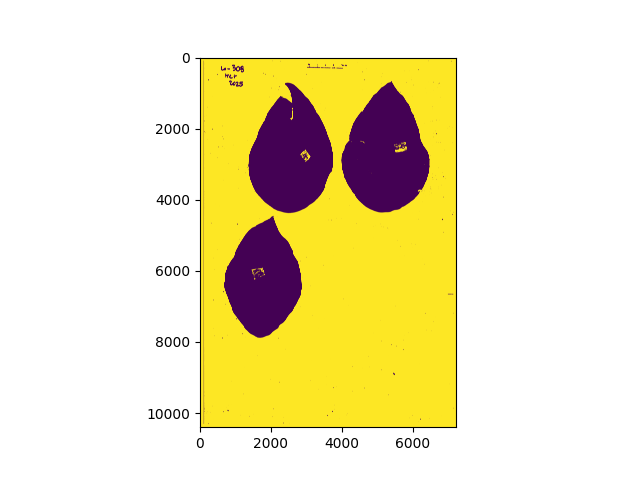

In [4]:
eroded = cv.erode(thresh, (5,5), iterations=15)
plt.figure()
plt.imshow(eroded)

In [5]:
thresh = eroded

In [6]:
#identify contours
contours = cv.findContours(thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)

In [7]:
#filter out objects that are not leaves
min_area = 250000   # Minimum area threshold
max_area = 10000000   # Maximum area threshold

filtered_contours = [cnt for cnt in contours if min_area < cv.contourArea(cnt) < max_area]

In [8]:
#output = np.zeros_like(thresh)
sorted_contours= sorted(filtered_contours, key=cv.contourArea, reverse= True)

<IPython.core.display.Javascript object>


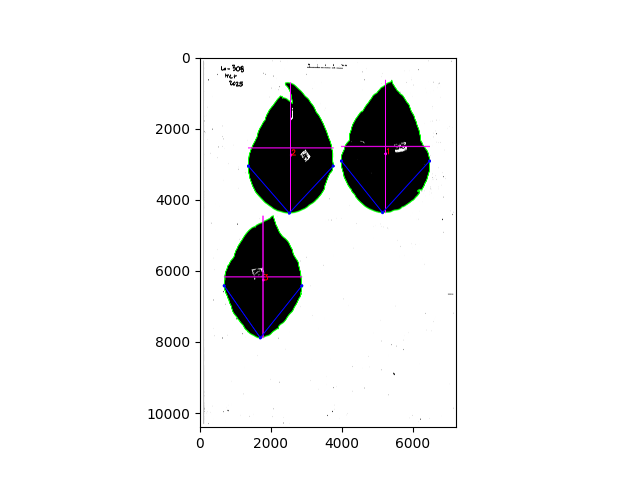

In [9]:
object_info = []  # To store info of each object

output_cp = cv.cvtColor(thresh, cv.COLOR_GRAY2BGR)

cv.drawContours(output_cp, sorted_contours, -1, (0, 255, 0), 30)

for idx, contour in enumerate(sorted_contours):
    
    #Get centroid
    M = cv.moments(contour)
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    cv.circle(output_cp, (cx, cy), 40, (255, 0, 255), -1) 
    
    #Get bounding box around each contour
    x_leaf, y_leaf, w_leaf, h_leaf = cv.boundingRect(contour)

    #Draw rectangle and label it
    #cv.rectangle(output_cp, (x, y), (x + w, y + h), (0, 255, 0), 30)
    
    #Show width line
    cv.line(output_cp, (x_leaf, y_leaf + h_leaf//2), (x_leaf + w_leaf, y_leaf + h_leaf//2), (255, 0, 255), 30)  
    
    #Show height line
    cv.line(output_cp, (x_leaf + w_leaf // 2, y_leaf), (x_leaf + w_leaf // 2, y_leaf + h_leaf), (255, 0, 255), 30)
    
    #Get angle from base to middle
    
    #Step 1: Identify base of leaf
    lowest_point = tuple(contour[contour[:, :, 1].argmax()][0])
    cv.circle(output_cp, lowest_point, 45, (255,0,0), -1)  # Blue dot at lowest point
    x0, y0 = lowest_point
    
    #Step 2: Identify widest part of leaf
    #for line 1: from lowest point to left-most point
    leftmost_point = tuple(contour[contour[:,:,0].argmin()][0])
    x1, y1 = leftmost_point
    
    
    #for line 2: from lowest point to right-most point
    rightmost_point = tuple(contour[contour[:,:,0].argmax()][0])
    #cv.circle(output_cp, rightmost_point, 45, (255,0,0), -1)
    x2, y2 = rightmost_point
    
    #Choose highest y point
    #if bool((y + h//2)<y1)
    if bool(y1>y2):
        y1 = y1
    else:
        y1 = y2
    
    
    #draw line 1 
    cv.line(output_cp, (x0,y0), (x1,y1),(255, 0, 0), 30) 
    #draw line 2 
    #cv.line(output_cp, (x0,y0), (x2,y2),(255, 0, 0), 30) 
    #matching leftmost point height
    cv.line(output_cp, (x0,y0), (x2,y1),(255, 0, 0), 30) 
    
    
    #Draw circles
    #leftmost
    cv.circle(output_cp, (x1,y1), 45, (255,0,0), -1)
    #rightmost
    cv.circle(output_cp, (x2,y1), 45, (255,0,0), -1)
    
    
    
    #Create vectors
    v1 = np.array([x1,y1]) - np.array([x0,y0])
    #matching leftmost point height
    v2 = np.array([x2,y1]) - np.array([x0,y0])

    # Calculate angle in radians (some arithmetic)
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    #arithmetic part 2
    angle_rad = np.arccos(cos_theta)

    # Convert to degrees
    angle_deg = np.degrees(angle_rad)
    
    
    # Put id_number at the center
    cv.putText(output_cp, text=str(idx+1), org=(cx, cy), 
               fontFace=cv.FONT_HERSHEY_SIMPLEX,
               fontScale=7, color=(0,0,255), 
               thickness=25, lineType=cv.LINE_AA)  # Black text
        
    
    # Store object data
    object_info.append({
        'Object_ID': idx + 1,
        'width': w_leaf,        # Width of object
        'height': h_leaf,        # Height of object
        'base_mid_angle': np.rint(angle_deg).astype(int) #Angle between base and middle of leaf
    })
    
plt.figure()    
plt.imshow(cv.cvtColor(output_cp, cv.COLOR_BGR2RGB))

<IPython.core.display.Javascript object>


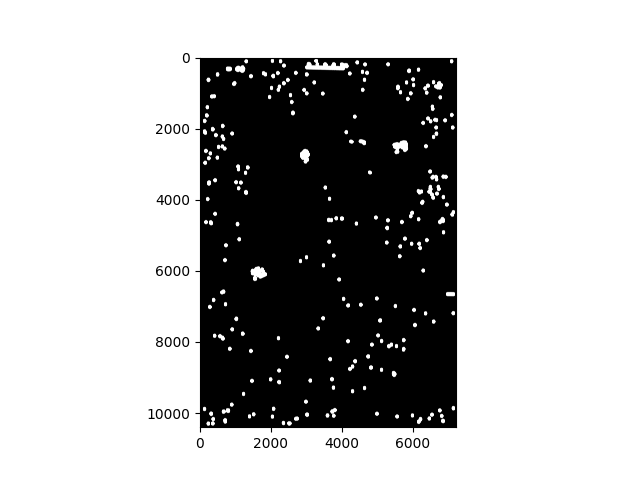

In [10]:
#filtering IN small contours
small_min_area = 50
small_max_area = 5000
small_contours  = [cnt for cnt in contours if small_min_area < cv.contourArea(cnt) < small_max_area]

# Create a blank image to draw contours on (or use the original image)
cnt_mask = np.zeros_like(im)
d0 =100
cv.drawContours(cnt_mask, small_contours, -1, (255, 255, 255), d0)
#cnt_mask = cv.dilate(cnt_mask,(5,5), iterations=30)
#draw circle wherever there is a contour
for cnt in small_contours:
    
    #Get centroid
    M = cv.moments(cnt)
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    #d = int(cv.contourArea(cnt)//15)
    #d = int(cv.arcLength(cnt,True)/2)
    d=50
    cv.circle(cnt_mask, (cx, cy), d, (255, 255, 255), -1) 
#cnt_mask = cv.dilate(cnt_mask,(155,155), iterations=30)
plt.figure()
plt.imshow(cnt_mask)

<IPython.core.display.Javascript object>


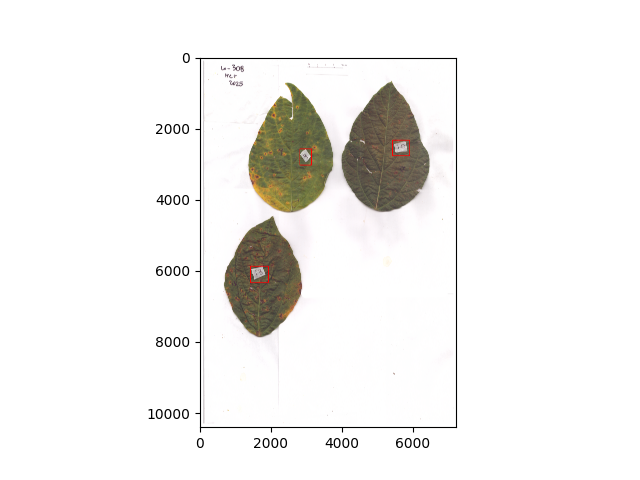

In [11]:
im_og = im.copy()

for contour in sorted_contours:

    #Get each leaf's bounding box (this is in the previous big chunk already)
    x_leaf, y_leaf, w_leaf, h_leaf = cv.boundingRect(contour)

    #Subset leaf from tag mask and get contours
    label = cv.cvtColor(cnt_mask[y_leaf:y_leaf+h_leaf, x_leaf:x_leaf+w_leaf], cv.COLOR_BGR2GRAY)
    tag_contour = cv.findContours(label, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    tag_contour = imutils.grab_contours(tag_contour)
    
    #Keep only biggest contour
    tag_contour= max(tag_contour, key = cv.contourArea)
    
    #Get biggest contour coordinates
    x_tag,y_tag,w_tag,h_tag = cv.boundingRect(tag_contour)
    x_tag = x_tag + x_leaf#-25
    y_tag = y_tag + y_leaf#-25
    w_tag = w_tag + 40
    h_tag = h_tag + 40
    cv.rectangle(im_og,(x_tag,y_tag),(x_tag+w_tag,y_tag+h_tag),(255,0,0),20)

    #Subset tag in original iamge
    tag_im = im_og[y_tag:y_tag+h_tag, x_tag:x_tag+w_tag]

    
plt.figure()
#plt.imshow(tag_im, cmap="gray")
plt.imshow(im_og, cmap="gray")